In [1]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [2]:
path=os.getcwd()
path

'/media/data/home/darcy/master_summary'

In [3]:
file=pd.read_csv(path+'/datasets/household_consumption.csv').loc[3186:13097] #  2007/05/01 00:00~2008/06/16 23:00
file.info()

datetime=file['Datetime']

file=file.drop(columns=['Datetime'])
#training data: 2007/05/01 00:00~2008/02/08 23:00, testing data: 2008/02/09 00:00~2008/06/16 23:00
data=(file-file[3186:10001].min())/(file[3186:10001].max()-file[3186:10001].min()) 
scale=[file[3186:10001].max().tolist(),file[3186:10001].min().tolist()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 3186 to 13097
Data columns (total 8 columns):
Global_active_power      9912 non-null float64
Global_reactive_power    9912 non-null float64
Voltage                  9912 non-null float64
Global_intensity         9912 non-null float64
Sub_metering_1           9912 non-null float64
Sub_metering_2           9912 non-null float64
Sub_metering_3           9912 non-null float64
Datetime                 9912 non-null object
dtypes: float64(7), object(1)
memory usage: 619.6+ KB


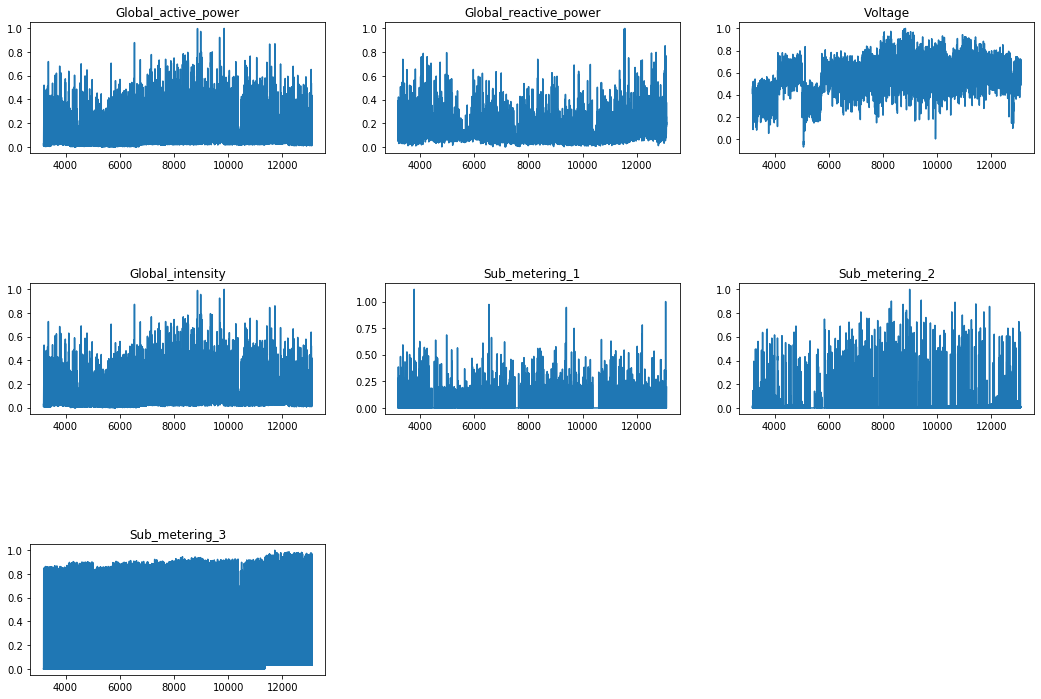

In [4]:
plt.figure(figsize=(18,12))
for i in range(len(file.columns)):
    plt.subplot(331+i)
    plt.plot(file[file.columns[i]])
    plt.title(file.columns[i],rotation=0)
plt.subplots_adjust(hspace = 1.0)
#plt.legend(data.columns,loc='upper left')

In [4]:
data1=data.values
scale

[[6.496033333333336,
  0.6540666666666668,
  249.04433333333333,
  28.2,
  43.38333333333333,
  46.43333333333333,
  19.733333333333334],
 [0.1486666666666666,
  0.027266666666666682,
  227.422,
  0.6933333333333328,
  0.0,
  0.0,
  0.0]]

# generate inputs and outputs

In [5]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors


def make_io(input_len,output_len,neighbors,split_size,shuffle=True):
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    package1=[[],[],[]]
    package2=[[],[],[]]
    data_len=data1.shape[0]
    data_dim=data1.shape[1]

    
    
    for j in range(data_len-input_len-output_len):
        one_x=[]
        one_y=[]
        i=neighbors[0]
        s=[scale[0][i],scale[1][i]] #min/ max
        for k in neighbors:
            one_x.append(data1[j:j+input_len,k].reshape(input_len,-1))
            one_y.append(data1[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
        one_x=np.concatenate(one_x,axis=1)
        one_y=np.concatenate(one_y,axis=1)
        one_data=[one_x.tolist(),one_y.tolist(),s]
            
        if j<(data_len-split_size):
            dataset1.append(one_data)
        else:
            dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2


# training function

In [6]:
def train(inputs, epochs, input_dim, input_len, output_len, split, model, loss_func, folder, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(data.columns[target])
    
    
    dataset1,dataset2=make_io(input_len,output_len,inputs,split)
    dataset3,dataset4=make_io(input_len,output_len,inputs,split,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.001
        elif j>500 and j<2000:
            rate=0.0001
        else:
            rate=0.00001
            
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        #training_loss=util.compute_loss_ver2(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        #testing_loss=util.compute_loss_ver2(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        #test_mape=util.mape(model(X_test.to(gpu))[0][:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,data.columns[target], target, 
                     scale, path+ '/results/plots/household_consumption/'+method+'/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, X_test_valid
    

# set gpu and loss function

In [7]:
importlib.reload(util)
#importlib.reload(src.model_recon)

<module 'src.util' from '/media/data/home/darcy/master_summary/src/util.py'>

In [7]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


# train models 

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
    (W): Linear(in_features=40, out_features=40, bias=False)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_intensity
number of parmeters: 23013
epoch:0
training mae loss:0.31743955612182617
testing mae loss:0.29216381907463074
testing mape:2.303603
epoch:100
training mae loss:0.09700161591172218
testing mae loss:0.095980

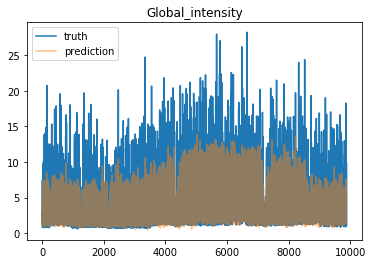

<Figure size 432x288 with 0 Axes>

In [9]:
import src.model

method='bahdanau'

targets=[3]
input_dim=7
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=24
output_length=12

split=3096
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length, method=method)
    print(model)
    
    X_train,X_test=train(inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [34]:
import src.model_recon

method='dot'

targets=[0]
input_dim=7
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=24
output_length=12

split=3096
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model_recon.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length, method=method)
    print(model)
    
    X_train,X_test=train(inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    # plot_attention(model, X_train, X_tesbt, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/reconstruct/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
    (deconvs): ModuleList(
      (0): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
      (1): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
      (2): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
      (3): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
      (4): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
      (5): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
      (6): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
   

TypeError: tuple indices must be integers or slices, not tuple

In [14]:
model

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)

# show results

In [46]:
i=2
method='general'
file_name=data.columns[i]
model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')

In [47]:
print(file_name)
inputs=make_neighbor_list(target=i, input_dim=7)

#make_io(input_len,output_len,neighbors,shuffle=True)
dataset1, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, split_size=split ,shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
print(test_mae)
test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
print(test_mape)

Voltage
0.07408334
0.0066678165


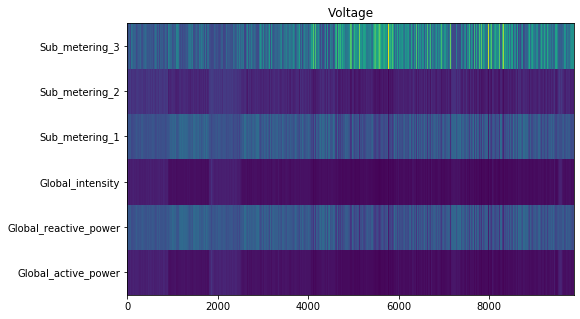

[[0.08470089733600616,
  0.23156222701072693,
  0.08063686639070511,
  0.2172132432460785,
  0.14372599124908447,
  0.24216076731681824],
 [0.08589372783899307,
  0.22334258258342743,
  0.08275794982910156,
  0.21221096813678741,
  0.14525170624256134,
  0.2505430281162262],
 [0.08580887317657471,
  0.22427789866924286,
  0.08342907577753067,
  0.20442916452884674,
  0.14457565546035767,
  0.2574792504310608],
 [0.08468922227621078,
  0.2159496694803238,
  0.08256903290748596,
  0.20484060049057007,
  0.1423414647579193,
  0.2696099579334259],
 [0.08381917327642441,
  0.2191515415906906,
  0.08132053911685944,
  0.20110967755317688,
  0.1403403878211975,
  0.27425864338874817],
 [0.08477968722581863,
  0.21501684188842773,
  0.08193649351596832,
  0.20450054109096527,
  0.14180287718772888,
  0.27196359634399414],
 [0.08482886850833893,
  0.21910712122917175,
  0.08133214712142944,
  0.20065294206142426,
  0.1406639963388443,
  0.2734149396419525],
 [0.08687208592891693,
  0.2177133560

<Figure size 432x288 with 0 Axes>

In [48]:
attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/household_consumption/'+method+'/')
attns

In [11]:
method='bahdanau'
for i in range(4):
    file_name=data.columns[i]
    print(file_name)
    model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
    inputs=make_neighbor_list(target=i, input_dim=7)

    dataset1, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, split_size=3096, shuffle=False)
    X_train=torch.FloatTensor(dataset1[0])
    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print(test_mae)
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print(test_mape)

Global_active_power
0.084844336
0.6078061
Global_reactive_power
0.07100193
0.37610587
Voltage
0.071724676
0.006453987
Global_intensity
0.08169347
0.5823898
